# Seasonal Sea Surface Temperature Anomalies for SOE
Laura Gruenburg
laura.gruenburg@noaa.gov
10/31/2024

In [3]:
# import relevant packages
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import regionmask
import READ_EDAB_Utilities_py as reupy
import pandas as pn
import numpy as np

In [10]:
# load the data
tos = xr.open_dataset('ocean_daily.19930101-20191231.tos.nc')

In [5]:
sst_obs = xr.open_dataset('sst.mon.mean.nc')

In [6]:
sst_obs

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 520, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1981-09-01 1981-10-01 ... 2024-12-01
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 2GB ...
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

In [3]:
tos

<xarray.Dataset> Size: 26GB
Dimensions:  (time: 9861, lon: 774, lat: 844)
Coordinates:
  * time     (time) datetime64[ns] 79kB 1993-01-01T12:00:00 ... 2019-12-31T12...
  * lon      (lon) float64 6kB 261.6 261.6 261.7 261.8 ... 323.8 323.8 323.9
  * lat      (lat) float64 7kB 5.273 5.335 5.398 5.461 ... 58.04 58.1 58.16
Data variables:
    tos      (time, lat, lon) float32 26GB ...
Attributes:
    NumFilesInSet:  1
    title:          NWA12_MOM6_v1.0
    grid_type:      regular
    grid_tile:      N/A
    history:        Derived and written at NOAA Physical Science Laboratory
    contact:        chia-wei.hsu@noaa.gov
    dataset:        regional mom6 regrid

In [7]:
# Load in the shapefile
epu = gpd.read_file('EPU_shape/EPU_NOESTUARIES.shp')

In [8]:
# Specify the EPUs
mab = epu[epu.EPU == 'MAB']
gom = epu[epu.EPU == 'GOM']
gb = epu[epu.EPU == 'GB']

In [11]:
tos_cropped = tos.sel(lat = slice(28, 48), lon = slice(280, 300))
sst_obs_cropped = sst_obs.sel(lat = slice(30,46), lon = slice(280,300))

In [12]:
mab_tos = reupy.crop_nd(tos_cropped, 'lon', 'lat', mab).resample(time = 'QS-JAN').mean().mean(['lat','lon'])
mab_obs = reupy.crop_nd(sst_obs_cropped, 'lon', 'lat', mab).resample(time = 'QS-JAN').mean().mean(['lat','lon'])

KeyboardInterrupt: 

In [14]:
# Subset data to only within each EPU and average in space and resample to quarterly
mab_tos = reupy.crop_nd(tos_cropped, 'lon', 'lat', mab).resample(time = 'QS-JAN').mean().mean(['lat','lon'])
gom_tos = reupy.crop_nd(tos_cropped, 'lon', 'lat', gom).resample(time = 'QS-JAN').mean().mean(['lat','lon'])
gb_tos = reupy.crop_nd(tos_cropped, 'lon', 'lat', gb).resample(time = 'QS-JAN').mean().mean(['lat','lon'])

# Subset data to only within each EPU and average in space and resample to quarterly
mab_obs = reupy.crop_nd(sst_obs_cropped, 'lon', 'lat', mab).resample(time = 'QS-JAN').mean().mean(['lat','lon'])
gom_obs = reupy.crop_nd(sst_obs_cropped, 'lon', 'lat', gom).resample(time = 'QS-JAN').mean().mean(['lat','lon'])
gb_obs = reupy.crop_nd(sst_obs_cropped, 'lon', 'lat', gb).resample(time = 'QS-JAN').mean().mean(['lat','lon'])

In [13]:
# NEW CLIMATOLOGY as of 12/11/2024 1991-2020 or whatvere part of that your time series has

mab_tos_clim = reupy.crop_nd(tos_cropped, 'lon', 'lat', mab).sel(time = slice('1993-01-01','2020-12-31')).resample(time = 'QS-JAN').mean().groupby('time.month').mean('time').mean(['lat','lon'])
mab_obs_clim = reupy.crop_nd(sst_obs_cropped, 'lon', 'lat', mab).sel(time = slice('1993-01-01','2020-12-31')).resample(time = 'QS-JAN').mean().groupby('time.month').mean('time').mean(['lat','lon'])

#gom_tos_clim = gom_tos.sel(time = slice('1993-01-01','2020-12-31')).groupby('time.month').mean('time')
#gb_tos_clim = gb_tos.sel(time = slice('1993-01-01','2020-12-31')).groupby('time.month').mean('time')



In [16]:
# Create climatologies
mab_tos_clim = mab_tos.sel(time = slice('1993-01-01','2010-12-31')).groupby('time.month').mean('time')
gom_tos_clim = gom_tos.sel(time = slice('1993-01-01','2010-12-31')).groupby('time.month').mean('time')
gb_tos_clim = gb_tos.sel(time = slice('1993-01-01','2010-12-31')).groupby('time.month').mean('time')

# Create climatologies
mab_obs_clim = mab_obs.sel(time = slice('1993-01-01','2010-12-31')).groupby('time.month').mean('time')
gom_obs_clim = gom_obs.sel(time = slice('1993-01-01','2010-12-31')).groupby('time.month').mean('time')
gb_obs_clim = gb_obs.sel(time = slice('1993-01-01','2010-12-31')).groupby('time.month').mean('time')

In [17]:
mab_tos_anom = mab_tos.groupby('time.month') - mab_tos_clim
gom_tos_anom = gom_tos.groupby('time.month') - gom_tos_clim
gb_tos_anom = gb_tos.groupby('time.month') - gb_tos_clim

mab_obs_anom = mab_obs.groupby('time.month') - mab_obs_clim
gom_obs_anom = gom_obs.groupby('time.month') - gom_obs_clim
gb_obs_anom = gb_obs.groupby('time.month') - gb_obs_clim

In [31]:
tos_season = 'start'

for i in range(108):
    if mab_tos_anom.month[i] == 1:
        tos_season = np.append(tos_season,'Winter')
    if mab_tos_anom.month[i] == 4:
        tos_season = np.append(tos_season,'Spring')
    if mab_tos_anom.month[i] == 7:
        tos_season = np.append(tos_season, 'Summer')
    if mab_tos_anom.month[i] == 10:
        tos_season = np.append(tos_season, 'Fall')
tos_season = tos_season[1:]        

In [32]:
obs_season = 'start'

for i in range(174):
    if mab_obs_anom.month[i] == 1:
        obs_season = np.append(obs_season,'Winter')
    if mab_obs_anom.month[i] == 4:
        obs_season = np.append(obs_season,'Spring')
    if mab_obs_anom.month[i] == 7:
        obs_season = np.append(obs_season, 'Summer')
    if mab_obs_anom.month[i] == 10:
        obs_season = np.append(obs_season, 'Fall')
obs_season = obs_season[1:]    

In [33]:
df_mab = pn.DataFrame({'Time': pn.to_datetime(mab_tos_anom.time).year,
                      'Season': tos_season,
                      'Value': mab_tos_anom.tos,
                      'EPU': 'MAB',
                      'Unit': 'degrees C'})

df_mab_obs = pn.DataFrame({'Time': pn.to_datetime(mab_obs_anom.time).year,
                      'Season': obs_season,
                      'Value': mab_obs_anom.sst,
                      'EPU': 'MAB',
                      'Unit': 'degrees C'})

In [34]:
df_gom = pn.DataFrame({'Time': pn.to_datetime(gom_tos_anom.time).year,
                      'Season': tos_season,
                      'Value': gom_tos_anom.tos,
                      'EPU': 'GOM',
                      'Unit': 'degrees C'})

df_gom_obs = pn.DataFrame({'Time': pn.to_datetime(gom_obs_anom.time).year,
                      'Season': obs_season,
                      'Value': gom_obs_anom.sst,
                      'EPU': 'GOM',
                      'Unit': 'degrees C'})

In [35]:
df_gb = pn.DataFrame({'Time': pn.to_datetime(gb_tos_anom.time).year,
                      'Season': tos_season,
                      'Value': gb_tos_anom.tos,
                      'EPU': 'GB',
                      'Unit': 'degrees C'})

df_gb_obs = pn.DataFrame({'Time': pn.to_datetime(gb_obs_anom.time).year,
                      'Season': obs_season,
                      'Value': gb_obs_anom.sst,
                      'EPU': 'GB',
                      'Unit': 'degrees C'})

In [18]:
gom_obs_anom

<xarray.Dataset> Size: 3kB
Dimensions:  (time: 174)
Coordinates:
  * time     (time) datetime64[ns] 1kB 1981-07-01 1981-10-01 ... 2024-10-01
    month    (time) int64 1kB 7 10 1 4 7 10 1 4 7 10 ... 7 10 1 4 7 10 1 4 7 10
Data variables:
    sst      (time) float32 696B -1.202 -0.1632 0.4799 ... 1.866 1.361 1.008

In [38]:
TOS

,Time,Season,Value,EPU,Unit
0,1993,Winter,-1.363818,MAB,degrees C
1,1993,Spring,-0.929884,MAB,degrees C
2,1993,Summer,0.267357,MAB,degrees C
3,1993,Fall,-0.186795,MAB,degrees C
4,1994,Winter,-0.999297,MAB,degrees C
...,...,...,...,...,...
319,2018,Fall,0.684707,GB,degrees C
320,2019,Winter,0.568569,GB,degrees C
321,2019,Spring,0.557523,GB,degrees C
322,2019,Summer,1.042936,GB,degrees C


In [37]:
TOS = pn.concat([df_mab,df_gom,df_gb]).reset_index(drop = True)
TOS_OBS = pn.concat([df_mab_obs,df_gom_obs,df_gb_obs]).reset_index(drop = True)

Text(0.5, 0.98, 'Winter Sea Surface Temperature Anomaly')

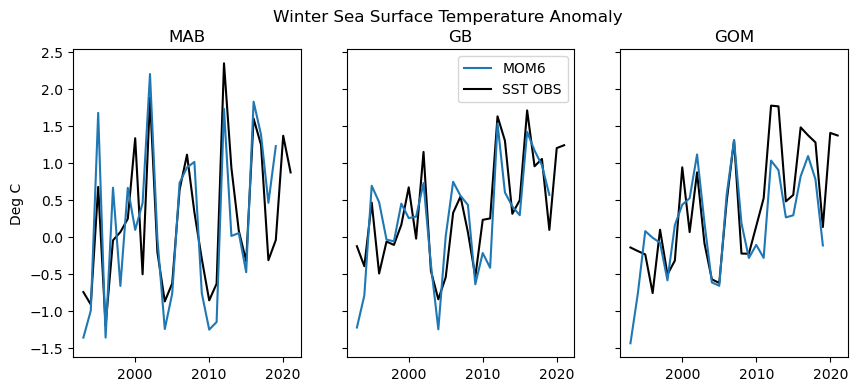

In [51]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = [10,4], sharey = True)
ax[0].plot(TOS[(TOS.EPU == 'MAB') & (TOS.Season == 'Winter')].Time, TOS[(TOS.EPU == 'MAB') & (TOS.Season == 'Winter')].Value, label = 'MOM6')
ax[0].plot(TOS_OBS[(TOS_OBS.EPU == 'MAB') & (TOS_OBS.Season == 'Winter')].Time[11:-3], TOS_OBS[(TOS_OBS.EPU == 'MAB') & (TOS_OBS.Season == 'Winter')].Value[11:-3], c = 'k', label = 'GLORYS', zorder = 0)
ax[0].set_title('MAB')

ax[1].plot(TOS[(TOS.EPU == 'GB') & (TOS.Season == 'Winter')].Time, TOS[(TOS.EPU == 'GB') & (TOS.Season == 'Winter')].Value, label = 'MOM6')
ax[1].plot(TOS_OBS[(TOS_OBS.EPU == 'GB') & (TOS_OBS.Season == 'Winter')].Time[11:-3], TOS_OBS[(TOS_OBS.EPU == 'GB') & (TOS_OBS.Season == 'Winter')].Value[11:-3], c = 'k', label = 'SST OBS', zorder = 0)
ax[1].set_title('GB')
ax[1].legend()

ax[2].plot(TOS[(TOS.EPU == 'GOM') & (TOS.Season == 'Winter')].Time, TOS[(TOS.EPU == 'GOM') & (TOS.Season == 'Winter')].Value)
ax[2].plot(TOS_OBS[(TOS_OBS.EPU == 'GOM') & (TOS_OBS.Season == 'Winter')].Time[11:-3], TOS_OBS[(TOS_OBS.EPU == 'GOM') & (TOS_OBS.Season == 'Winter')].Value[11:-3], c = 'k', label = 'GLORYS', zorder = 0)
ax[2].set_title('GOM')

ax[0].set_ylabel('Deg C')
fig.suptitle('Winter Sea Surface Temperature Anomaly')


Text(0.5, 0.98, 'Spring Sea Surface Temperature Anomaly')

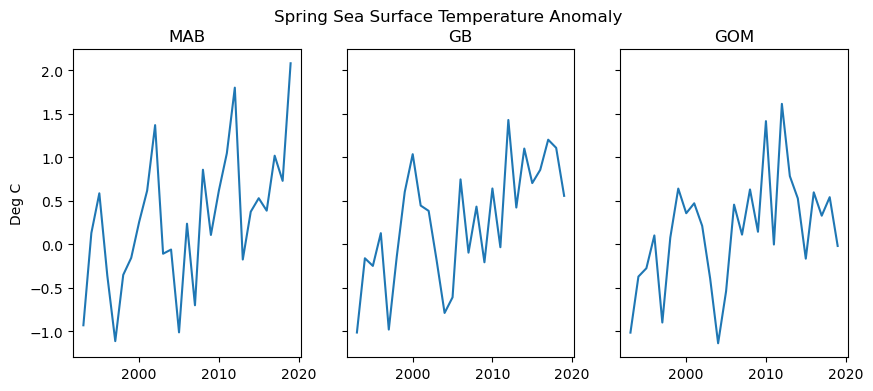

In [34]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = [10,4], sharey = True)
ax[0].plot(TOS[(TOS.EPU == 'MAB') & (TOS.Season == 'Spring')].Time, TOS[(TOS.EPU == 'MAB') & (TOS.Season == 'Spring')].Value)
ax[0].set_title('MAB')
ax[1].plot(TOS[(TOS.EPU == 'GB') & (TOS.Season == 'Spring')].Time, TOS[(TOS.EPU == 'GB') & (TOS.Season == 'Spring')].Value)
ax[1].set_title('GB')
ax[2].plot(TOS[(TOS.EPU == 'GOM') & (TOS.Season == 'Spring')].Time, TOS[(TOS.EPU == 'GOM') & (TOS.Season == 'Spring')].Value)
ax[2].set_title('GOM')

ax[0].set_ylabel('Deg C')
fig.suptitle('Spring Sea Surface Temperature Anomaly')


Text(0.5, 0.98, 'Spring Sea Surface Temperature Anomaly')

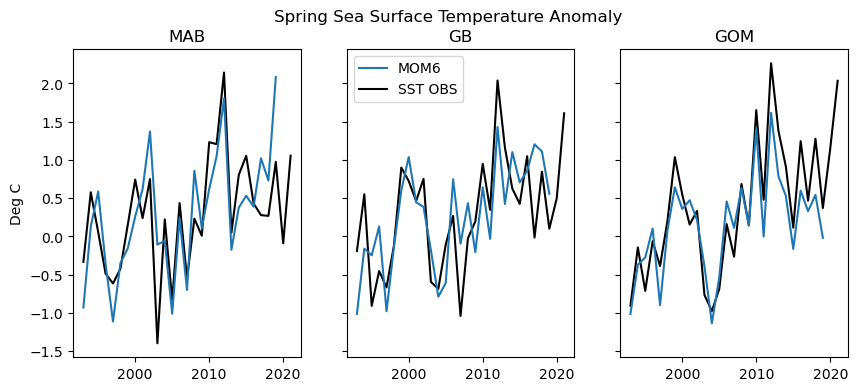

In [52]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = [10,4], sharey = True)
ax[0].plot(TOS[(TOS.EPU == 'MAB') & (TOS.Season == 'Spring')].Time, TOS[(TOS.EPU == 'MAB') & (TOS.Season == 'Spring')].Value, label = 'MOM6')
ax[0].plot(TOS_OBS[(TOS_OBS.EPU == 'MAB') & (TOS_OBS.Season == 'Spring')].Time[11:-3], TOS_OBS[(TOS_OBS.EPU == 'MAB') & (TOS_OBS.Season == 'Spring')].Value[11:-3], c = 'k', label = 'GLORYS', zorder = 0)
ax[0].set_title('MAB')

ax[1].plot(TOS[(TOS.EPU == 'GB') & (TOS.Season == 'Spring')].Time, TOS[(TOS.EPU == 'GB') & (TOS.Season == 'Spring')].Value, label = 'MOM6')
ax[1].plot(TOS_OBS[(TOS_OBS.EPU == 'GB') & (TOS_OBS.Season == 'Spring')].Time[11:-3], TOS_OBS[(TOS_OBS.EPU == 'GB') & (TOS_OBS.Season == 'Spring')].Value[11:-3], c = 'k', label = 'SST OBS', zorder = 0)
ax[1].set_title('GB')
ax[1].legend()

ax[2].plot(TOS[(TOS.EPU == 'GOM') & (TOS.Season == 'Spring')].Time, TOS[(TOS.EPU == 'GOM') & (TOS.Season == 'Spring')].Value)
ax[2].plot(TOS_OBS[(TOS_OBS.EPU == 'GOM') & (TOS_OBS.Season == 'Spring')].Time[11:-3], TOS_OBS[(TOS_OBS.EPU == 'GOM') & (TOS_OBS.Season == 'Spring')].Value[11:-3], c = 'k', label = 'GLORYS', zorder = 0)
ax[2].set_title('GOM')

ax[0].set_ylabel('Deg C')
fig.suptitle('Spring Sea Surface Temperature Anomaly')

Text(0.5, 0.98, 'Summer Sea Surface Temperature Anomaly')

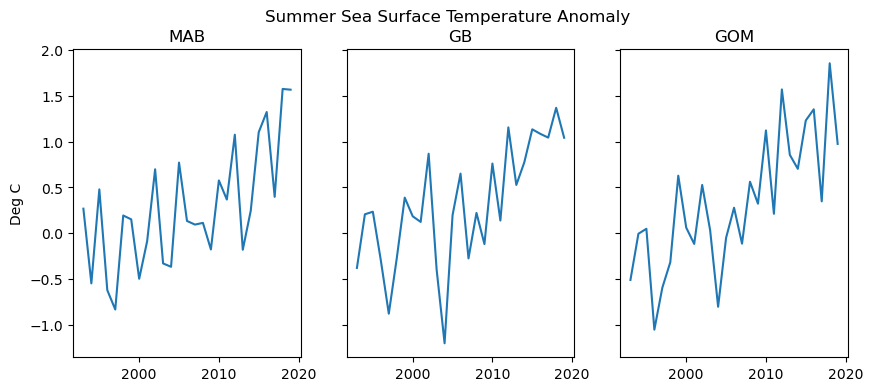

In [35]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = [10,4], sharey = True)
ax[0].plot(TOS[(TOS.EPU == 'MAB') & (TOS.Season == 'Summer')].Time, TOS[(TOS.EPU == 'MAB') & (TOS.Season == 'Summer')].Value)
ax[0].set_title('MAB')
ax[1].plot(TOS[(TOS.EPU == 'GB') & (TOS.Season == 'Summer')].Time, TOS[(TOS.EPU == 'GB') & (TOS.Season == 'Summer')].Value)
ax[1].set_title('GB')
ax[2].plot(TOS[(TOS.EPU == 'GOM') & (TOS.Season == 'Summer')].Time, TOS[(TOS.EPU == 'GOM') & (TOS.Season == 'Summer')].Value)
ax[2].set_title('GOM')

ax[0].set_ylabel('Deg C')
fig.suptitle('Summer Sea Surface Temperature Anomaly')


Text(0.5, 0.98, 'Summer Sea Surface Temperature Anomaly')

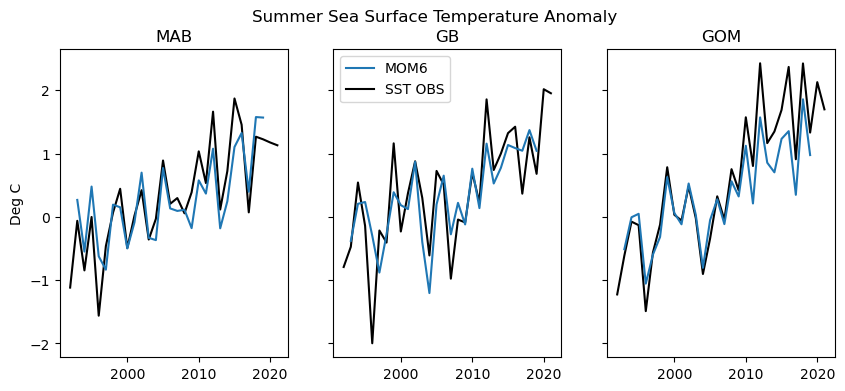

In [53]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = [10,4], sharey = True)
ax[0].plot(TOS[(TOS.EPU == 'MAB') & (TOS.Season == 'Summer')].Time, TOS[(TOS.EPU == 'MAB') & (TOS.Season == 'Summer')].Value, label = 'MOM6')
ax[0].plot(TOS_OBS[(TOS_OBS.EPU == 'MAB') & (TOS_OBS.Season == 'Summer')].Time[11:-3], TOS_OBS[(TOS_OBS.EPU == 'MAB') & (TOS_OBS.Season == 'Summer')].Value[11:-3], c = 'k', label = 'GLORYS', zorder = 0)
ax[0].set_title('MAB')

ax[1].plot(TOS[(TOS.EPU == 'GB') & (TOS.Season == 'Summer')].Time, TOS[(TOS.EPU == 'GB') & (TOS.Season == 'Summer')].Value, label = 'MOM6')
ax[1].plot(TOS_OBS[(TOS_OBS.EPU == 'GB') & (TOS_OBS.Season == 'Summer')].Time[11:-3], TOS_OBS[(TOS_OBS.EPU == 'GB') & (TOS_OBS.Season == 'Summer')].Value[11:-3], c = 'k', label = 'SST OBS', zorder = 0)
ax[1].set_title('GB')
ax[1].legend()

ax[2].plot(TOS[(TOS.EPU == 'GOM') & (TOS.Season == 'Summer')].Time, TOS[(TOS.EPU == 'GOM') & (TOS.Season == 'Summer')].Value)
ax[2].plot(TOS_OBS[(TOS_OBS.EPU == 'GOM') & (TOS_OBS.Season == 'Summer')].Time[11:-3], TOS_OBS[(TOS_OBS.EPU == 'GOM') & (TOS_OBS.Season == 'Summer')].Value[11:-3], c = 'k', label = 'GLORYS', zorder = 0)
ax[2].set_title('GOM')

ax[0].set_ylabel('Deg C')
fig.suptitle('Summer Sea Surface Temperature Anomaly')

Text(0.5, 0.98, 'Fall Sea Surface Temperature Anomaly')

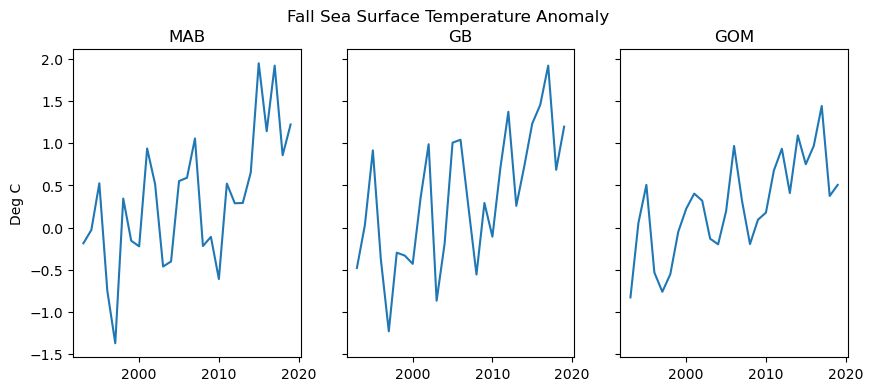

In [36]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = [10,4], sharey = True)
ax[0].plot(TOS[(TOS.EPU == 'MAB') & (TOS.Season == 'Fall')].Time, TOS[(TOS.EPU == 'MAB') & (TOS.Season == 'Fall')].Value)
ax[0].set_title('MAB')
ax[1].plot(TOS[(TOS.EPU == 'GB') & (TOS.Season == 'Fall')].Time, TOS[(TOS.EPU == 'GB') & (TOS.Season == 'Fall')].Value)
ax[1].set_title('GB')
ax[2].plot(TOS[(TOS.EPU == 'GOM') & (TOS.Season == 'Fall')].Time, TOS[(TOS.EPU == 'GOM') & (TOS.Season == 'Fall')].Value)
ax[2].set_title('GOM')

ax[0].set_ylabel('Deg C')
fig.suptitle('Fall Sea Surface Temperature Anomaly')


Text(0.5, 0.98, 'Fall Sea Surface Temperature Anomaly')

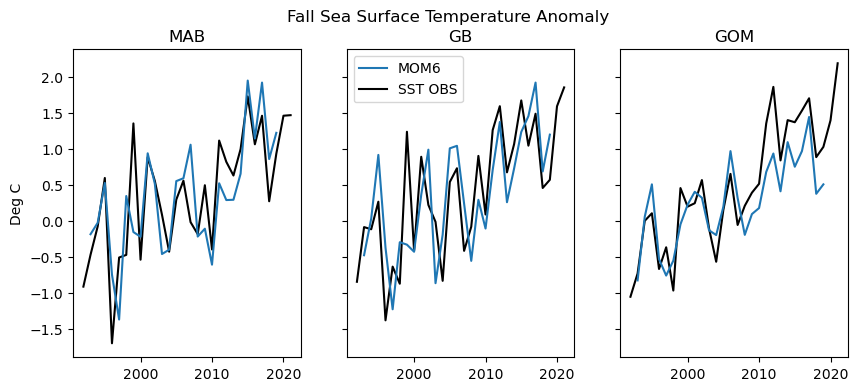

In [54]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = [10,4], sharey = True)
ax[0].plot(TOS[(TOS.EPU == 'MAB') & (TOS.Season == 'Fall')].Time, TOS[(TOS.EPU == 'MAB') & (TOS.Season == 'Fall')].Value, label = 'MOM6')
ax[0].plot(TOS_OBS[(TOS_OBS.EPU == 'MAB') & (TOS_OBS.Season == 'Fall')].Time[11:-3], TOS_OBS[(TOS_OBS.EPU == 'MAB') & (TOS_OBS.Season == 'Fall')].Value[11:-3], c = 'k', label = 'GLORYS', zorder = 0)
ax[0].set_title('MAB')

ax[1].plot(TOS[(TOS.EPU == 'GB') & (TOS.Season == 'Fall')].Time, TOS[(TOS.EPU == 'GB') & (TOS.Season == 'Fall')].Value, label = 'MOM6')
ax[1].plot(TOS_OBS[(TOS_OBS.EPU == 'GB') & (TOS_OBS.Season == 'Fall')].Time[11:-3], TOS_OBS[(TOS_OBS.EPU == 'GB') & (TOS_OBS.Season == 'Fall')].Value[11:-3], c = 'k', label = 'SST OBS', zorder = 0)
ax[1].set_title('GB')
ax[1].legend()

ax[2].plot(TOS[(TOS.EPU == 'GOM') & (TOS.Season == 'Fall')].Time, TOS[(TOS.EPU == 'GOM') & (TOS.Season == 'Fall')].Value)
ax[2].plot(TOS_OBS[(TOS_OBS.EPU == 'GOM') & (TOS_OBS.Season == 'Fall')].Time[11:-3], TOS_OBS[(TOS_OBS.EPU == 'GOM') & (TOS_OBS.Season == 'Fall')].Value[11:-3], c = 'k', label = 'GLORYS', zorder = 0)
ax[2].set_title('GOM')

ax[0].set_ylabel('Deg C')
fig.suptitle('Fall Sea Surface Temperature Anomaly')

In [17]:

epu_titles = ['MAB_EPU', 'GOM_EPU', 'SS_EPU', 'GB_EPU', 'NEUS_LME', 'SS_LME']
epu_values = [4, 5, 0, 1, 2, 3]
n_epus = len(epu_titles)

for i in range(n_epus):
        hind_i = tos_forecast.sel(epu=epu_values[i])
        epu_name = epu_titles[epu_values[i]]
    
hind_i  = tos_forecast.sel(epu=epu_values[0])
epu_name = epu_titles[epu_values[0]]
plt.plot(hind_i.tos[:,57,:])
plt.plot(np.nanmean(hind_i.tos[:,57,:],1), c = 'k', linewidth = 3)
epu_name

NameError: name 'tos_forecast' is not defined

In [37]:
TOS.to_csv('tos_hindcast_1993_2019.csv')

In [56]:
tos_forecast = xr.open_dataset('nwa12_hind_epu_annual_tos.nc')

In [63]:
tos_forecast

<xarray.Dataset> Size: 140kB
Dimensions:  (member: 10, time: 58, epu: 6, lead: 10)
Coordinates:
  * member   (member) int64 80B 1 2 3 4 5 6 7 8 9 10
  * time     (time) datetime64[ns] 464B 1965-01-01 1966-01-01 ... 2022-01-01
Dimensions without coordinates: epu, lead
Data variables:
    tos      (epu, lead, time, member) float32 139kB ...

In [65]:
tos_data = tos_forecast.tos[0,:,57,0]
tos_forecast_mab = pn.DataFrame({'Time': np.arange(2023, 2033),
                                 'Lead': np.arange(1,11),
              'Val': tos_data.values,
              'EPU': 'MAB',
              'e_member': 1,
              'Unit': 'degrees C'})

for i in range(1,10):
    tos_data = tos_forecast.tos[0,:,57,i]
    tos_df = pn.DataFrame({'Time': np.arange(2023, 2033),
                           'Lead': np.arange(1,11),
              'Val': tos_data.values,
              'EPU': 'MAB',
              'e_member': i+1,
              'Unit': 'degrees C'})
    tos_forecast_mab = pn.concat([tos_forecast_mab, tos_df])

tos_mean = pn.DataFrame({'Time': np.arange(2023, 2033),
                         'Lead': np.arange(1,11),
                         'Val': np.nanmean(tos_forecast.tos[0,:,57,:],1),
                         'EPU': 'MAB',
                         'e_member': 'Ensemble Mean',
                         'Unit': 'degrees C'})
tos_forecast_mab = pn.concat([tos_forecast_mab, tos_mean])

In [66]:
tos_data = tos_forecast.tos[1,:,57,0]
tos_forecast_gom = pn.DataFrame({'Time': np.arange(2023, 2033),
                                 'Lead': np.arange(1,11),
              'Val': tos_data.values,
              'EPU': 'GOM',
              'e_member': 1,
              'Unit': 'degrees C'})

for i in range(1,10):
    tos_data = tos_forecast.tos[1,:,57,i]
    tos_df = pn.DataFrame({'Time': np.arange(2023, 2033),
                           'Lead': np.arange(1,11),
              'Val': tos_data.values,
              'EPU': 'GOM',
              'e_member': i+1,
              'Unit': 'degrees C'})
    tos_forecast_gom = pn.concat([tos_forecast_gom, tos_df])


tos_mean = pn.DataFrame({'Time': np.arange(2023, 2033),
                         'Lead': np.arange(1,11),
                         'Val': np.nanmean(tos_forecast.tos[1,:,57,:],1),
                         'EPU': 'GOM',
                         'e_member': 'Ensemble Mean',
                         'Unit': 'degrees C'})
tos_forecast_gom = pn.concat([tos_forecast_gom, tos_mean])

In [67]:
tos_data = tos_forecast.tos[3,:,57,0]
tos_forecast_gb = pn.DataFrame({'Time': np.arange(2023, 2033),
                                'Lead': np.arange(1,11),
              'Val': tos_data.values,
              'EPU': 'GB',
              'e_member': 1,
              'Unit': 'degrees C'})

for i in range(1,10):
    tos_data = tos_forecast.tos[3,:,57,i]
    tos_df = pn.DataFrame({'Time': np.arange(2023, 2033),
                           'Lead': np.arange(1,11),
              'Val': tos_data.values,
              'EPU': 'GB',
              'e_member': i+1,
              'Unit': 'degrees C'})
    tos_forecast_gb = pn.concat([tos_forecast_gb, tos_df])

tos_mean = pn.DataFrame({'Time': np.arange(2023, 2033),
                         'Lead': np.arange(1,11),
                         'Val': np.nanmean(tos_forecast.tos[3,:,57,:],1),
                         'EPU': 'GB',
                         'e_member': 'Ensemble Mean',
                         'Unit': 'degrees C'})
tos_forecast_gb = pn.concat([tos_forecast_gb, tos_mean])

In [68]:
tos_10forecast = pn.concat([tos_forecast_mab, tos_forecast_gom, tos_forecast_gb]).reset_index(drop = True)

In [69]:
tos_10forecast

,Time,Lead,Val,EPU,e_member,Unit
0,2023,1,0.585255,MAB,1,degrees C
1,2024,2,0.899135,MAB,1,degrees C
2,2025,3,1.073020,MAB,1,degrees C
3,2026,4,1.833349,MAB,1,degrees C
4,2027,5,1.587018,MAB,1,degrees C
...,...,...,...,...,...,...
325,2028,6,0.760833,GB,Ensemble Mean,degrees C
326,2029,7,0.514280,GB,Ensemble Mean,degrees C
327,2030,8,0.333196,GB,Ensemble Mean,degrees C
328,2031,9,0.359613,GB,Ensemble Mean,degrees C


Text(0.5, 1.0, 'SST Anomaly, GB')

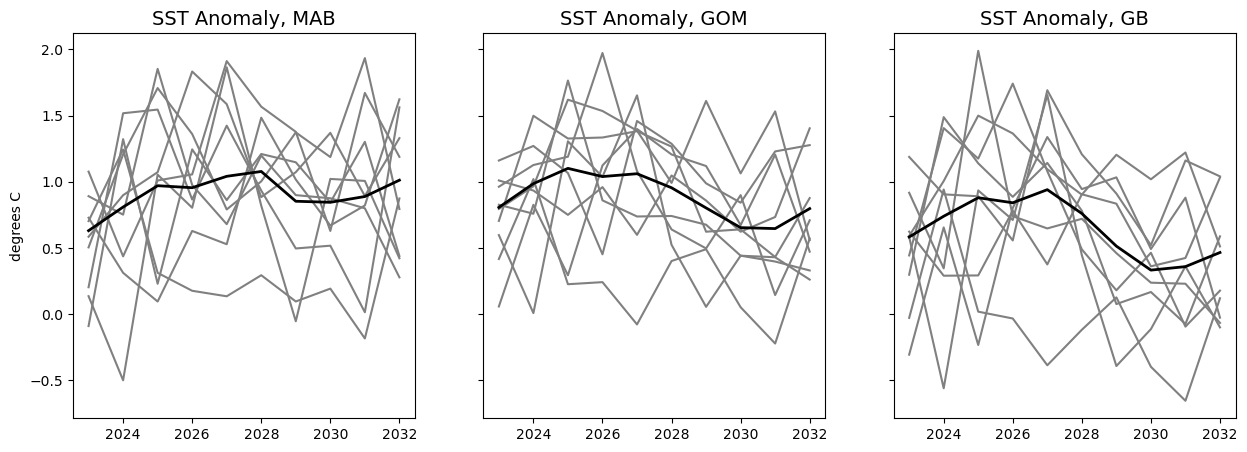

In [24]:
fig, ax = plt.subplots(ncols = 3, figsize = [15,5], sharey = True)
mab_tos = tos_10forecast[tos_10forecast.EPU == "MAB"]
for i in range(10):
    ax[0].plot(mab_tos[mab_tos.e_member == i].Time, mab_tos[mab_tos.e_member == i].Val, color = 'grey')
ax[0].plot(mab_tos[mab_tos.e_member == "Ensemble Mean"].Time, mab_tos[mab_tos.e_member == "Ensemble Mean"].Val, color = 'k', linewidth = 2)
ax[0].set_title('SST Anomaly, MAB', fontsize = 14)
ax[0].set_ylabel('degrees C')

gom_tos = tos_10forecast[tos_10forecast.EPU == "GOM"]
for i in range(10):
    ax[1].plot(gom_tos[gom_tos.e_member == i].Time, gom_tos[gom_tos.e_member == i].Val, color = 'grey')
ax[1].plot(gom_tos[gom_tos.e_member == "Ensemble Mean"].Time, gom_tos[gom_tos.e_member == "Ensemble Mean"].Val, color = 'k', linewidth = 2)
ax[1].set_title('SST Anomaly, GOM', fontsize = 14)

gb_tos = tos_10forecast[tos_10forecast.EPU == "GB"]
for i in range(10):
    ax[2].plot(gb_tos[gb_tos.e_member == i].Time, gb_tos[gb_tos.e_member == i].Val, color = 'grey')
ax[2].plot(gb_tos[gb_tos.e_member == "Ensemble Mean"].Time, gb_tos[gb_tos.e_member == "Ensemble Mean"].Val, color = 'k', linewidth = 2)
ax[2].set_title('SST Anomaly, GB', fontsize = 14)

In [26]:
#tos_10forecast.to_csv('tos_10forecast.csv')

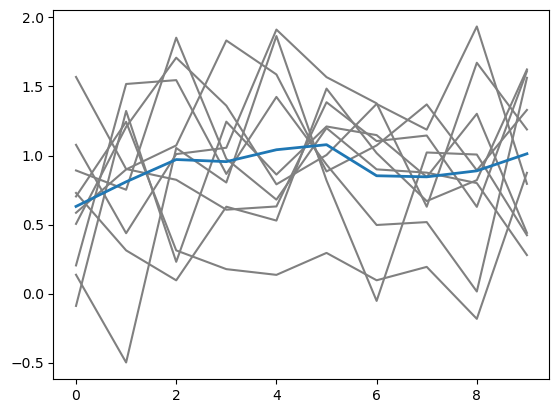

In [158]:
import numpy as np
i = 0
plt.plot(tos_10.tos[i,:,57,0],c='grey')
plt.plot(tos_10.tos[i,:,57,1],c='grey')
plt.plot(tos_10.tos[i,:,57,2],c='grey')
plt.plot(tos_10.tos[i,:,57,3],c='grey')
plt.plot(tos_10.tos[i,:,57,4],c='grey')
plt.plot(tos_10.tos[i,:,57,5],c='grey')
plt.plot(tos_10.tos[i,:,57,6],c='grey')
plt.plot(tos_10.tos[i,:,57,7],c='grey')
plt.plot(tos_10.tos[i,:,57,8],c='grey')
plt.plot(tos_10.tos[i,:,57,9],c='grey')
plt.plot(np.nanmean(tos_10.tos[i,:,57,:],1), linewidth = 2)
#plt.plot(np.nanmean(tos_10.tos[5,:,57,:],1))

In [25]:
mab_tos[mab_tos.e_member == i].Val

80    0.703541
81    1.243993
82    0.312698
83    0.177029
84    0.135506
85    0.294575
86    0.096266
87    0.193372
88   -0.183071
89    0.874619
Name: Val, dtype: float32

In [43]:
y_top = mab_tos[mab_tos.e_member != 'Ensemble Mean'].groupby('Time').max('Val')
y_bottom = mab_tos[mab_tos.e_member != 'Ensemble Mean'].groupby('Time').min('Val')

AttributeError: 'Dataset' object has no attribute 'e_member'

In [44]:
plt.fill_between(np.unique(mab_tos.Time), y_top.Val, y_bottom.Val, alpha = 0.5)
plt.plot(mab_tos[mab_tos.e_member == "Ensemble Mean"].Time, mab_tos[mab_tos.e_member == "Ensemble Mean"].Val, color = 'k', linewidth = 2)


AttributeError: 'Dataset' object has no attribute 'Time'

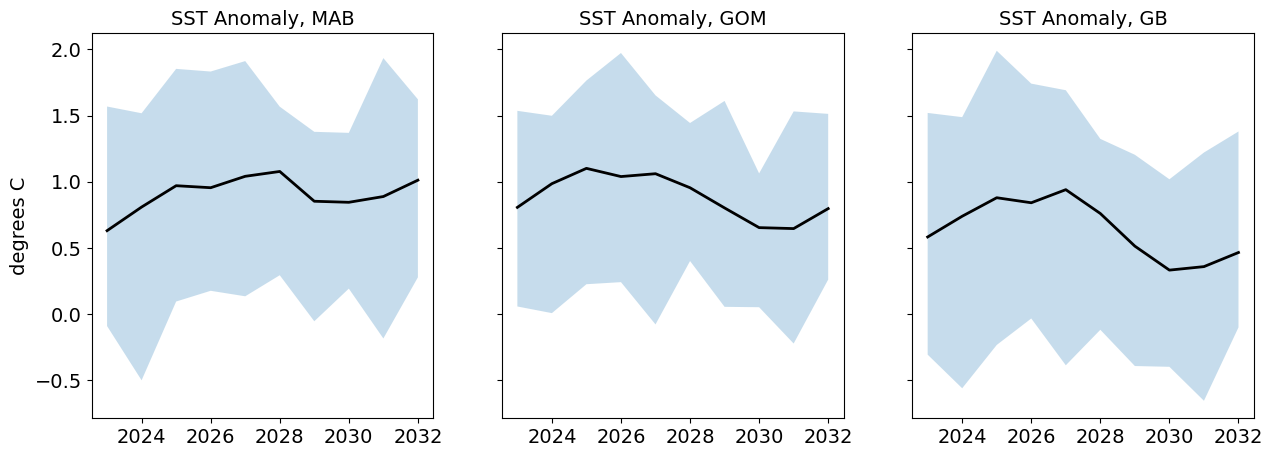

In [70]:
fig, ax = plt.subplots(ncols = 3, figsize = [15,5], sharey = True)
mab_tos = tos_10forecast[tos_10forecast.EPU == "MAB"]
ax[0].fill_between(np.unique(mab_tos.Time), 
                   mab_tos[mab_tos.e_member != 'Ensemble Mean'].groupby('Time').max('Val').Val, 
                   mab_tos[mab_tos.e_member != 'Ensemble Mean'].groupby('Time').min('Val').Val, 
                   alpha = 0.25)
ax[0].plot(mab_tos[mab_tos.e_member == "Ensemble Mean"].Time, mab_tos[mab_tos.e_member == "Ensemble Mean"].Val, color = 'k', linewidth = 2)
ax[0].set_title('SST Anomaly, MAB', fontsize = 14)
ax[0].set_ylabel('degrees C', fontsize = 14)
ax[0].tick_params(labelsize = 14)

gom_tos = tos_10forecast[tos_10forecast.EPU == "GOM"]
ax[1].fill_between(np.unique(gom_tos.Time),                    
                   gom_tos[gom_tos.e_member != 'Ensemble Mean'].groupby('Time').max('Val').Val, 
                   gom_tos[gom_tos.e_member != 'Ensemble Mean'].groupby('Time').min('Val').Val,  
                   alpha = 0.25)
ax[1].plot(gom_tos[gom_tos.e_member == "Ensemble Mean"].Time, gom_tos[gom_tos.e_member == "Ensemble Mean"].Val, color = 'k', linewidth = 2)
ax[1].set_title('SST Anomaly, GOM', fontsize = 14)
ax[1].tick_params(labelsize = 14)

gb_tos = tos_10forecast[tos_10forecast.EPU == "GB"]
ax[2].fill_between(np.unique(gb_tos.Time),                    
                   gb_tos[gb_tos.e_member != 'Ensemble Mean'].groupby('Time').max('Val').Val, 
                   gb_tos[gb_tos.e_member != 'Ensemble Mean'].groupby('Time').min('Val').Val,  
                   alpha = 0.25)
ax[2].plot(gb_tos[gb_tos.e_member == "Ensemble Mean"].Time, gb_tos[gb_tos.e_member == "Ensemble Mean"].Val, color = 'k', linewidth = 2)
ax[2].set_title('SST Anomaly, GB', fontsize = 14)
ax[2].tick_params(labelsize = 14)


Text(0.5, 0, 'Lead (years)')

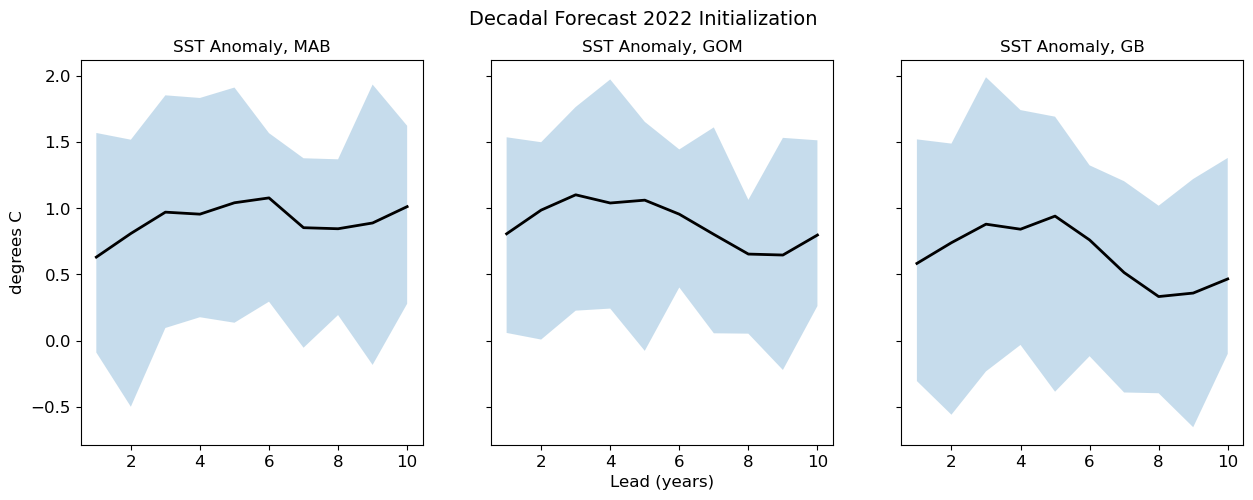

In [76]:
fig, ax = plt.subplots(ncols = 3, figsize = [15,5], sharey = True)
mab_tos = tos_10forecast[tos_10forecast.EPU == "MAB"]
ax[0].fill_between(np.unique(mab_tos.Lead), 
                   mab_tos[mab_tos.e_member != 'Ensemble Mean'].groupby('Time').max('Val').Val, 
                   mab_tos[mab_tos.e_member != 'Ensemble Mean'].groupby('Time').min('Val').Val, 
                   alpha = 0.25)
ax[0].plot(mab_tos[mab_tos.e_member == "Ensemble Mean"].Lead, mab_tos[mab_tos.e_member == "Ensemble Mean"].Val, color = 'k', linewidth = 2)
ax[0].set_title('SST Anomaly, MAB', fontsize = 12)
ax[0].set_ylabel('degrees C', fontsize = 12)
ax[0].tick_params(labelsize = 12)

gom_tos = tos_10forecast[tos_10forecast.EPU == "GOM"]
ax[1].fill_between(np.unique(gom_tos.Lead),                    
                   gom_tos[gom_tos.e_member != 'Ensemble Mean'].groupby('Time').max('Val').Val, 
                   gom_tos[gom_tos.e_member != 'Ensemble Mean'].groupby('Time').min('Val').Val,  
                   alpha = 0.25)
ax[1].plot(gom_tos[gom_tos.e_member == "Ensemble Mean"].Lead, gom_tos[gom_tos.e_member == "Ensemble Mean"].Val, color = 'k', linewidth = 2)
ax[1].set_title('SST Anomaly, GOM', fontsize = 12)
ax[1].tick_params(labelsize = 12)

gb_tos = tos_10forecast[tos_10forecast.EPU == "GB"]
ax[2].fill_between(np.unique(gb_tos.Lead),                    
                   gb_tos[gb_tos.e_member != 'Ensemble Mean'].groupby('Time').max('Val').Val, 
                   gb_tos[gb_tos.e_member != 'Ensemble Mean'].groupby('Time').min('Val').Val,  
                   alpha = 0.25)
ax[2].plot(gb_tos[gb_tos.e_member == "Ensemble Mean"].Lead, gb_tos[gb_tos.e_member == "Ensemble Mean"].Val, color = 'k', linewidth = 2)
ax[2].set_title('SST Anomaly, GB', fontsize = 12)
ax[2].tick_params(labelsize = 12)

fig.suptitle('Decadal Forecast 2022 Initialization', fontsize = 14)

ax[1].set_xlabel('Lead (years)', fontsize = 12)

Text(0.5, 1.0, 'SST Anomaly, GB')

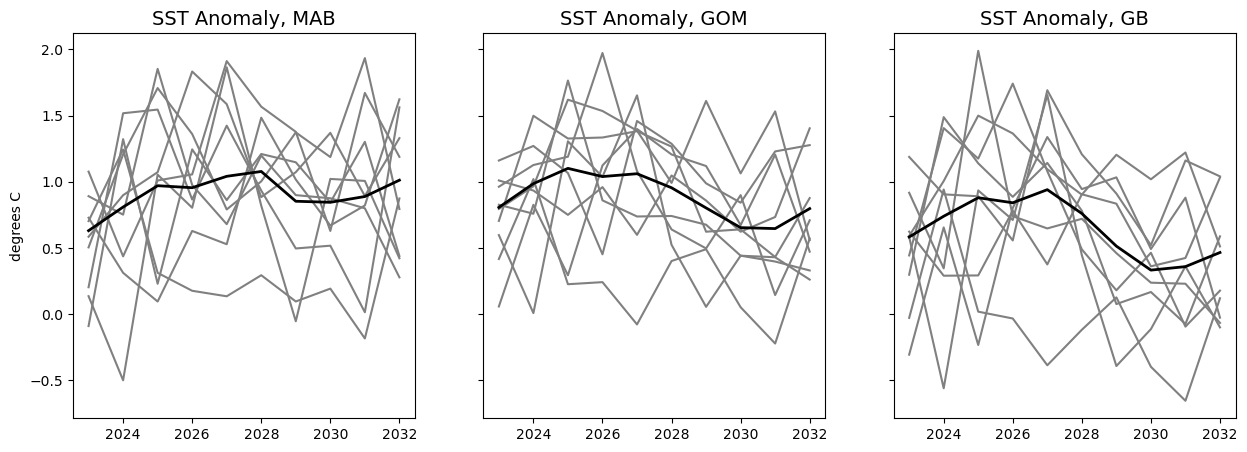

In [43]:
fig, ax = plt.subplots(ncols = 3, figsize = [15,5], sharey = True)
mab_tos = tos_10forecast[tos_10forecast.EPU == "MAB"]
for i in range(10):
    ax[0].plot(mab_tos[mab_tos.e_member == i].Time, mab_tos[mab_tos.e_member == i].Val, color = 'grey')
ax[0].plot(mab_tos[mab_tos.e_member == "Ensemble Mean"].Time, mab_tos[mab_tos.e_member == "Ensemble Mean"].Val, color = 'k', linewidth = 2)
ax[0].set_title('SST Anomaly, MAB', fontsize = 14)
ax[0].set_ylabel('degrees C')

gom_tos = tos_10forecast[tos_10forecast.EPU == "GOM"]
for i in range(10):
    ax[1].plot(gom_tos[gom_tos.e_member == i].Time, gom_tos[gom_tos.e_member == i].Val, color = 'grey')
ax[1].plot(gom_tos[gom_tos.e_member == "Ensemble Mean"].Time, gom_tos[gom_tos.e_member == "Ensemble Mean"].Val, color = 'k', linewidth = 2)
ax[1].set_title('SST Anomaly, GOM', fontsize = 14)

gb_tos = tos_10forecast[tos_10forecast.EPU == "GB"]
for i in range(10):
    ax[2].plot(gb_tos[gb_tos.e_member == i].Time, gb_tos[gb_tos.e_member == i].Val, color = 'grey')
ax[2].plot(gb_tos[gb_tos.e_member == "Ensemble Mean"].Time, gb_tos[gb_tos.e_member == "Ensemble Mean"].Val, color = 'k', linewidth = 2)
ax[2].set_title('SST Anomaly, GB', fontsize = 14)

OSError: [Errno -75] NetCDF: Malformed or unexpected Constraint: b'https://psl.noaa.gov/cgi-bin/mddb2/plot.pl?doplot=0&varID=156646&fileID=0&itype=0&variable=sst&levelType=Surface&level_units=&level=Surface&timetype=mon&fileTimetype=mon&year1=1990&month1=1&day1=1&hr1=00%20Z&year2=2024&month2=12&day2=31&hr2=00%20Z&region=custom&area_north=46&area_west=-80&area_east=-60&area_south=32&centerLat=0.0&centerLon=270.0'